In [1]:
import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

2024-10-16 12:04:55.274153: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 12:04:55.329903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 12:04:55.329936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 12:04:55.331442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 12:04:55.344742: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps as cm
from tqdm import tqdm
import scipy
from numpy.polynomial.hermite import hermval
import keras
from time import time
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
tf.config.run_functions_eagerly(False)
print("Eager execution enabled:", tf.executing_eagerly())

Eager execution enabled: True


In [3]:
pi = tf.constant(np.pi)

tf.__version__

2024-10-16 12:04:59.755142: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-10-16 12:04:59.816844: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 9.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-10-16 12:05:00.034554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78750 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:e1:00.0, compute capability: 9.0


'2.15.0'

# Klein-Gordon equation

Let $a \in \mathbb{R}$ and $b>0$.  $$\left(\partial_t^2 - a^2 \nabla^2 + b\right)\psi(x,t)=0, \quad (x,t) \in [1, 5]\times [0,T], $$
with initial conditions $$ \psi(x,0) = a \cos\left(\frac{\pi}{2} x \right) \quad\text{and}\quad \psi_t(x,0)=b\mu\cos\left(\frac{\pi}{2}x\right),$$
and Dirichlet boundary conditions $$ \psi(1,t) = \psi(5,t) = 0,$$

where $$\mu = \sqrt{b +\frac{a^2 \pi^2}{4}}.$$

The exact solution is $$\psi(x,t) = \cos\left(\frac{\pi x}{2}\right) \left(a \cos\left(\mu t \right) + b\sin\left(\mu t\right)\right).$$

In [4]:
a = 2
b = 3
mu = np.sqrt(b + a**2 * np.pi**2 / 4)
t_max = 2
x_min = 1
x_max = 5

## define boundary condition

In [5]:

tbc=tf.linspace(0.,2.,100)
xbc1=tf.fill(tf.shape(tbc),1.)
Zbc1=tf.stack([xbc1,tbc],1)

ybc1=tf.zeros(tf.shape(tbc),1)

xbc2=tf.fill(tf.shape(tbc),5.)
Zbc2=tf.stack([xbc2,tbc],1)

ybc2=tf.zeros(tf.shape(tbc),1)

# initial condition
def initial_cond(x):
  return a*tf.cos(pi*x/2), b*mu*tf.cos(pi*x/2)
xic=tf.linspace(1.,5.,100)

Zin=tf.stack([xic, tf.fill(tf.shape(xic), 0.)],1)




## Boundary Condtions

In [6]:
x = tf.random.uniform((100, 1), minval=x_min + 1e-4, maxval=x_max - 1e-4)
t=tf.random.uniform((100,1),0.,2.)

X,T= tf.meshgrid(x,t)
Z =tf.stack([tf.reshape(X, [-1]), tf.reshape(T, [-1])], 1)

## calculating residual

In [7]:
def residual(xi_tt,xi_xx,xi,a):
  return (xi_tt-a**2*(xi_xx)+b*xi)**2


## Building model

In [8]:

def Klein_Gordon_model(num_layers=8, size_layer=60):
    model = keras.models.Sequential()

    # Input is 1-dimensional (time)
    model.add(keras.Input((2,)))

    for _ in range(num_layers):
        model.add(keras.layers.Dense(size_layer, activation='tanh',
                  kernel_initializer='glorot_normal'))

    # Output is 1-dimensional
    model.add(keras.layers.Dense(1))

    return model

## Define residual

In [9]:

def get_residual(Z, model, Zin, a):
    with tf.GradientTape(persistent=True) as tape:
        x = Z[:, 0:1]
        t = Z[:, 1:2]
        tape.watch(x)
        tape.watch(t)

        xi = model(tf.concat([x, t], -1), training=True)

        xi_t = tape.gradient(xi, t)
        xi_x = tape.gradient(xi, x)
    xi_tt = tape.gradient(xi_t, t)
    xi_xx = tape.gradient(xi_x, x)
    del tape

    with tf.GradientTape(persistent=True) as tape_ic:
        x_ic=Zin[:,0:1]
        t_ic = Zin[:, 1:2]
        tape_ic.watch(t_ic)
        tape_ic.watch(x_ic)
        xi_ic = model(tf.concat([x_ic, t_ic], -1), training=True)
        xi_ict = tape_ic.gradient(xi_ic, t_ic)
    del tape_ic

    return residual(xi_tt, xi_xx, xi, a), xi_ict

## Defining loss function

In [10]:
loss_weights=[1,1,1,1,1]
def loss_func(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a):

  res,xi_ict=get_residual(Z,model,Zin,a)
  loss_res=tf.reduce_mean(res)

  yin,yin_prime=initial_cond(Zin[:,0:1])


  loss_ic1=(model(Zin,training=True)-yin)**2
  loss_ic1=tf.reduce_mean(loss_ic1)

  loss_ic2=(xi_ict-yin_prime)**2
  loss_ic2=tf.reduce_mean(loss_ic2)

  loss_bc1=(model(Zbc1,training=True)-ybc1)**2
  loss_bc1=tf.reduce_mean(loss_bc1)

  loss_bc2=(model(Zbc2,training=True)-ybc2)**2
  loss_bc2=tf.reduce_mean(loss_bc2)
  over_loss=(loss_weights[0]*loss_res+ loss_weights[1]*loss_bc1+loss_weights[2]*loss_bc2 + loss_weights[3]*loss_ic1 +loss_weights[4]*loss_ic2)
  return over_loss,  (loss_res),(loss_bc1+loss_bc2),(loss_ic1+loss_ic2)

## definig single step gradient

In [11]:
def loss_grad(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a):
  with tf.GradientTape(persistent=True) as tape:
    loss,loss_res,loss_bc,loss_ic=loss_func(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a)

  grad_theta=tape.gradient(loss,model.trainable_weights)
  del tape

  return loss,grad_theta,loss_res,loss_bc,loss_ic


## Defining model objejct

In [12]:
model = Klein_Gordon_model()
optim = keras.optimizers.Adam(learning_rate=1e-4)

Epoch: 0  loss: 2.4815972  loss_res: 0.33204356  loss_bc: 1.4288602  loss_ic: 0.7206934
Epoch: 5000  loss: 0.19165578  loss_res: 0.015650446  loss_bc: 0.15111701  loss_ic: 0.024888333
Epoch: 10000  loss: 0.036410645  loss_res: 0.024877975  loss_bc: 0.0070129773  loss_ic: 0.0045196963
Epoch: 15000  loss: 0.0023841206  loss_res: 0.001558523  loss_bc: 0.00040136225  loss_ic: 0.00042423522
Epoch: 20000  loss: 0.003042257  loss_res: 0.0026421575  loss_bc: 0.00015220509  loss_ic: 0.0002478945
Epoch: 25000  loss: 0.00089095364  loss_res: 0.0007598928  loss_bc: 8.100774e-05  loss_ic: 5.0053073e-05
Epoch: 30000  loss: 0.0007156663  loss_res: 0.00060282124  loss_bc: 7.474366e-05  loss_ic: 3.8101403e-05
Epoch: 35000  loss: 0.00065375824  loss_res: 0.000531483  loss_bc: 7.718001e-05  loss_ic: 4.509523e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch: 40000  loss: 0.0008990319  loss_res: 0.00068797613  loss_bc: 0.00013676027  loss_ic: 7.42954e-05

 The loss is: 0.0008990318747237325

Computation time: 454.890034198761 seconds


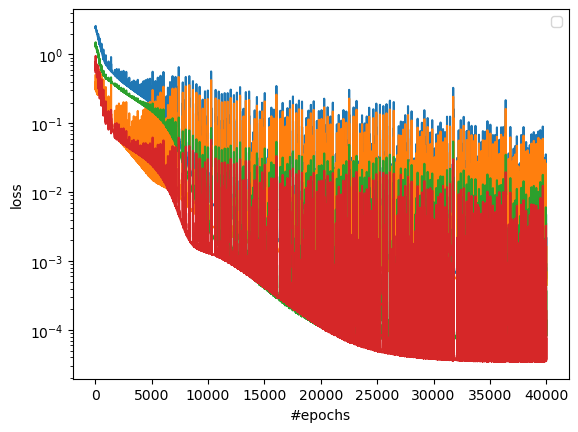

In [14]:
@tf.function
def train_step(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a,optimizer):
  loss, grad_theta,loss_res,loss_bc,loss_ic= loss_grad(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a)

  grads_and_vars = [(g, v) for g, v in zip(grad_theta, model.trainable_variables) if g is not None]
  optimizer.apply_gradients(grads_and_vars)

  #optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

  return loss,loss_res,loss_bc,loss_ic

N=40000

hist=[]

# Start timer
t_begin = time()
hist = []
histres = []
histbc = []
histic = []
for i in range(N+1):
    loss,loss_res,loss_bc,loss_ic = train_step(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a,optim)

    # Append current loss to hist
    hist.append(loss.numpy())
    histres.append(loss_res.numpy())
    histbc.append(loss_bc.numpy())
    histic.append(loss_ic.numpy())

    if i%5000 == 0:
      print("Epoch:",i," loss:", loss.numpy(), " loss_res:", loss_res.numpy(), " loss_bc:", loss_bc.numpy(), " loss_ic:", loss_ic.numpy() )

    #if i%500==0:
        #model.save('/content/drive/MyDrive/Klein_Gordon_model.h5')

# Print the loss
print('\n The loss is: {}'.format(hist[-1]))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t_begin))

# Print the learning curve
plt.semilogy(range(len(hist)), np.array(hist))
plt.semilogy(range(len(histres)), np.array(histres))
plt.semilogy(range(len(histbc)), np.array(histbc))
plt.semilogy(range(len(histic)), np.array(histic))
plt.xlabel('#epochs')
plt.ylabel('loss');

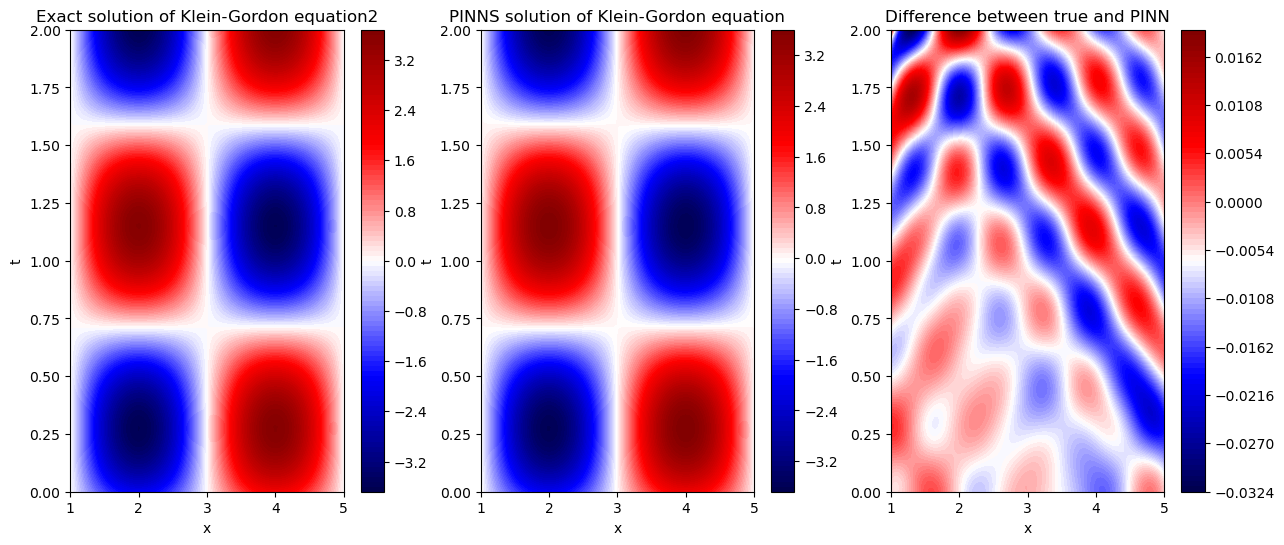

The average error in the percentage error is 0.7990


In [20]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
ZZ=tf.stack([tf.reshape(X,[-1]),tf.reshape(T,[-1])],1)


psi = np.cos(X*np.pi/2)*(a*np.cos(mu*T)+b*np.sin(mu*T))

fig,ax= plt.subplots(1,3,figsize=(15,6))
contour=ax[0].contourf(X, T, psi, cmap='seismic', levels=100)
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_title('Exact solution of Klein-Gordon equation2')
fig.colorbar(contour, ax=ax[0])

xi=model(ZZ).numpy()
xi1=xi.reshape(100,100)
contour=ax[1].contourf(X, T, xi1, cmap='seismic', levels=100)
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_title('PINNS solution of Klein-Gordon equation')
fig.colorbar(contour, ax=ax[1])



contour=ax[2].contourf(X, T, xi1-psi, cmap='seismic', levels=100)
ax[2].set_xlabel('x')
ax[2].set_ylabel('t')
ax[2].set_title('Difference between true and PINN')
fig.colorbar(contour, ax=ax[2])
plt.show()

perc_error=np.abs((xi1-psi))
perc_error=np.mean(perc_error)*100

print(f'The average error in the percentage error is {perc_error:.4f}')



## Different boundary conditions

Let $a \in \mathbb{R}$ and $b>0$.$$\left(\partial_t^2 - a^2 \nabla^2 + b\right)\psi(x,t)=0, \quad (x,t) \in [0, 4]\times [0,T], $$

with initial conditions $$ \psi(x,0) = ae^{-\frac{\pi x}{2}} \quad \text{and}\quad \psi_t(x,0)=b\mu e^{-\frac{\pi}{2}x}$$
and boundary conditions
$$\psi(0, t) = a\cos(\mu t) + b\sin(\mu t)\qquad \text{and}\qquad
 \psi(4,t) = e^{-2\pi}\left(a\cos(\mu t) + b\sin(\mu t)\right)$$

where $$\mu = \sqrt{b -\frac{a^2 \pi^2}{4}}.$$

The exact solution is $$\psi(x,t)=e^{-\frac{\pi}{2} x}\left( a\cos(\mu t)+b\sin(\mu t)\right).$$

In [21]:
a = 1.
b = 3.
mu = np.sqrt(b - a**2 * np.pi**2 / 4)
t_max = 12.
x_max = 4.

In [22]:
# Boundary

tbc=tf.linspace(0.,t_max,100)
xbc1=tf.fill(tf.shape(tbc),0.)
Zbc1=tf.stack([xbc1,tbc],1)


xbc2=tf.fill(tf.shape(tbc),x_max)
Zbc2=tf.stack([xbc2,tbc],1)

def boundary_condtion(t):
  return(a*tf.cos(mu*t)+b*tf.sin(mu*t),tf.exp(-2*pi)*(a*tf.cos(mu*t)+b*tf.sin(mu*t)))

ybc1=0; ybc2=0




# initial condition
xic=tf.linspace(0.,x_max,100)

Zin=tf.stack([xic, tf.fill(tf.shape(xic), 0.)],1)

def initial_cond_1(x):
  return a*tf.exp(-pi*x/2), b*mu*tf.exp(-pi*x/2)



# defining boundary
x = tf.random.uniform((100, 1), minval=0. + 1e-4, maxval=x_max - 1e-4)
t=tf.random.uniform((100,1),0.,t_max)

X,T= tf.meshgrid(x,t)
Z =tf.stack([tf.reshape(X, [-1]), tf.reshape(T, [-1])], 1)



In [23]:
loss_weights=[1,1,1,1,1]
def loss_func(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a):

  res,xi_ict=get_residual(Z,model,Zin,a)
  loss_res=tf.reduce_mean(res)

  yin,yin_prime=initial_cond_1(Zin[:,0:1])

  ybc1,ybc2=boundary_condtion(Zbc1[:,1:2])




  loss_ic1=(model(Zin,training=True)-yin)**2
  loss_ic1=tf.reduce_mean(loss_ic1)

  loss_ic2=(xi_ict-yin_prime)**2
  loss_ic2=tf.reduce_mean(loss_ic2)

  loss_bc1=(model(Zbc1,training=True)-ybc1)**2
  loss_bc1=tf.reduce_mean(loss_bc1)

  loss_bc2=(model(Zbc2,training=True)-ybc2)**2
  loss_bc2=tf.reduce_mean(loss_bc2)
  over_loss=(loss_weights[0]*loss_res+ loss_weights[1]*loss_bc1+loss_weights[2]*loss_bc2 + loss_weights[3]*loss_ic1 +loss_weights[4]*loss_ic2)
  return over_loss,  (loss_res),(loss_bc1+loss_bc2),(loss_ic1+loss_ic2)

In [33]:
model = Klein_Gordon_model()
optim = keras.optimizers.Adam(learning_rate=1e-4)

In [34]:
@tf.function
def train_step(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a,optimizer):
  loss, grad_theta,loss_res,loss_bc,loss_ic= loss_grad(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a)

  grads_and_vars = [(g, v) for g, v in zip(grad_theta, model.trainable_variables) if g is not None]
  optimizer.apply_gradients(grads_and_vars)

  #optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

  return loss,loss_res,loss_bc,loss_ic

N=40000
hist=[]

# Start timer
t_begin = time()
hist = []
histres = []
histbc = []
histic = []
for i in range(N+1):
    loss,loss_res,loss_bc,loss_ic = train_step(Z,model,Zin,Zbc1,Zbc2,ybc1,ybc2,a,optim)

    # Append current loss to hist
    hist.append(loss.numpy())
    histres.append(loss_res.numpy())
    histbc.append(loss_bc.numpy())
    histic.append(loss_ic.numpy())

    if i%5000 == 0:
      print("Epoch:",i," loss:", loss.numpy(), " loss_res:", loss_res.numpy(), " loss_bc:", loss_bc.numpy(), " loss_ic:", loss_ic.numpy() )

    #if i%500==0:
     #model.save('/content/drive/MyDrive/Klein_Gordon_model2.h5')

# Print the loss
print('\n The loss is: {}'.format(hist[-1]))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t_begin))

Epoch: 0  loss: 6.387855  loss_res: 0.3850232  loss_bc: 5.450728  loss_ic: 0.5521041
Epoch: 5000  loss: 0.00074235495  loss_res: 0.0005030604  loss_bc: 0.00022023238  loss_ic: 1.906216e-05
Epoch: 10000  loss: 0.00015516081  loss_res: 0.000114522794  loss_bc: 3.8347385e-05  loss_ic: 2.2906352e-06
Epoch: 15000  loss: 8.762481e-05  loss_res: 7.0109534e-05  loss_bc: 1.6461734e-05  loss_ic: 1.0535465e-06

 The loss is: 8.762480865698308e-05

Computation time: 176.1678807735443 seconds


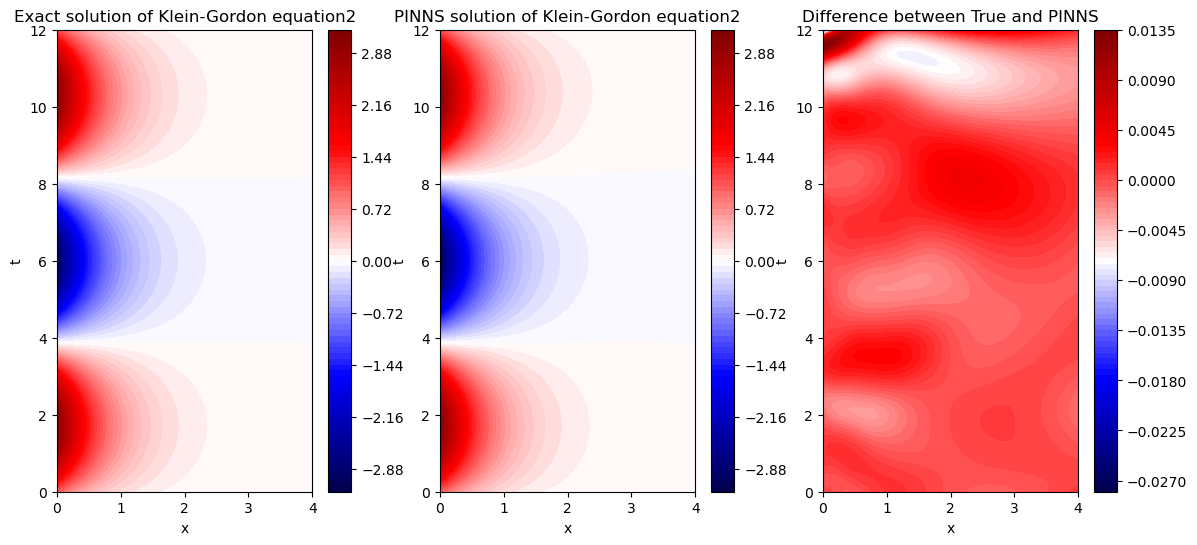

The average error in the percentage error is 0.1625


In [58]:
x = np.linspace(0, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
psi = np.exp(-X*np.pi/2)*(a*np.cos(mu*T)+b*np.sin(mu*T))

fig,ax= plt.subplots(1,3,figsize=(14,6))
contour=ax[0].contourf(X, T, psi, cmap='seismic', levels=100)
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_title('Exact solution of Klein-Gordon equation2')
fig.colorbar(contour, ax=ax[0])


ZZ=tf.stack([tf.reshape(X,[-1]),tf.reshape(T,[-1])],1)
xii=model(ZZ).numpy()
xii1=xii.reshape(100,100)

contour=ax[1].contourf(X, T, xii1, cmap='seismic', levels=100)
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_title('PINNS solution of Klein-Gordon equation2')
fig.colorbar(contour, ax=ax[1])


contour=ax[2].contourf(X, T, psi-xii1, cmap='seismic', levels=100)
ax[1].set_xlabel('x')
ax[2].set_xlabel('x')
ax[2].set_ylabel('t')
ax[2].set_title('Difference between True and PINNS')
fig.colorbar(contour, ax=ax[2])
plt.show()

perc_error = np.abs(xii1 - psi)
perc_error1 = np.mean(perc_error)*100

print(f'The average error in the percentage error is {perc_error1:.4f}')




# Lid-driven cavity problem

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) $$


$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) $$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$
with the initial condition $$u, v, p = 0 \; \text{everywhere},$$ and the boundary conditions
\begin{array}{l}
u=1\quad \text{at}\; y=2,\\
u, v=0 \quad \text{on the other boundaries},\\
\frac{\partial p}{\partial y}=0 \quad \text{at} \; y=0,\\
p=0\quad \text{at} \; y=2,\\
\frac{\partial p}{\partial x}=0 \quad\text{at} \; x=0,2.
\end{array}

## Boundary conditions

In [59]:
# parameters
rho = 1
nu = 0.1

#define boundary condition


xbc1=tf.linspace(0.,2.,10)
ybc1=tf.fill(tf.shape(xbc1),0.)
Zbc1=tf.stack([xbc1,ybc1],1)
ubc1=tf.zeros(tf.shape(xbc1),1)
vbc1=tf.zeros(tf.shape(xbc1),1)


ybc2=tf.linspace(0.,2.,10)
xbc2=tf.fill(tf.shape(ybc2),0.)
Zbc2=tf.stack([xbc2,ybc2],1)
ubc2=tf.zeros(tf.shape(ybc2),1)
vbc2=tf.zeros(tf.shape(ybc2),1)


ybc3=tf.linspace(0.,2.,10)
xbc3=tf.fill(tf.shape(ybc3),2.)
Zbc3=tf.stack([xbc3,ybc3],1)
ubc3=tf.zeros(tf.shape(ybc3),1)
vbc3=tf.zeros(tf.shape(ybc3),1)

xbc4=tf.linspace(0.,2.,10)
ybc4=tf.fill(tf.shape(xbc4),2.)
Zbc4=tf.stack([xbc4,ybc4],1)
ubc4=tf.ones(tf.shape(xbc4),1)
vbc4=tf.zeros(tf.shape(xbc4),1)
pbc4=tf.zeros(tf.shape(xbc4),1)


## Interior


In [60]:
x = tf.random.uniform((41, 1), minval=0, maxval=2)
y = tf.random.uniform((41, 1), minval=0, maxval=2)

X,Y= tf.meshgrid(x,y)
Z =tf.stack([tf.reshape(X, [-1]), tf.reshape(Y, [-1])], 1)

## calculating residual

In [61]:

def residual_x(u,v,dudx,dudy,dpdx,d2udx2,d2udy2):
  return (u*dudx+v*dudy+(1/rho)*dpdx-nu*(d2udx2+d2udy2))**2

def residual_y(u,v,dvdx,dvdy,dpdy,d2vdx2,d2vdy2):
  return (u*dvdx+v*dvdy+(1/rho)*dpdy-nu*(d2vdx2+d2vdy2))**2

def residual_poisson(d2pdx2,d2pdy2,dudx,dudy,dvdx,dvdy):
  return (d2pdx2+d2pdy2+rho*(dudx*dudx+2*(dudy*dvdx)+dvdy*dvdy))**2



## Building model

In [62]:

def lid_driven_cavity(num_layers=8, size_layer=60):
    model = keras.models.Sequential()

    # Input is 1-dimensional (time)
    model.add(keras.Input((2,)))

    for _ in range(num_layers):
        model.add(keras.layers.Dense(size_layer, activation='tanh',
                  kernel_initializer='glorot_normal'))

    # Output is 1-dimensional
    model.add(keras.layers.Dense(3,))

    return model

## Get residual

In [63]:
def get_residual(Zbc1,Zbc2,Zbc3,Z,model):
    with tf.GradientTape(persistent=True) as tape:
        x = Z[:, 0:1]
        y = Z[:, 1:2]
        tape.watch(x)
        tape.watch(y)

        U = model(tf.concat([x, y], -1), training=True)

        dudx = tape.gradient(U[:,0:1], x)
        dudy = tape.gradient(U[:,0:1], y)
        dvdx=  tape.gradient(U[:,1:2], x)
        dvdy=  tape.gradient(U[:,1:2], y)
        dpdx = tape.gradient(U[:,2:3], x)
        dpdy = tape.gradient(U[:,2:3], y)
    d2udx2 = tape.gradient(dudx, x)
    d2udy2 = tape.gradient(dudy, y)
    d2vdx2 = tape.gradient(dvdx, x)
    d2vdy2 = tape.gradient(dvdy, y)
    d2pdx2= tape.gradient(dpdx, x)
    d2pdy2= tape.gradient(dpdy, y)
    del tape

    with tf.GradientTape(persistent=True) as tape_bc1:
        xbc1=Zbc1[:,0:1]
        ybc1 = Zbc1[:, 1:2]
        tape_bc1.watch(xbc1)
        tape_bc1.watch(ybc1)
        Ubc1 = model(tf.concat([xbc1, ybc1], -1), training=True)
        dpdy1 = tape_bc1.gradient(Ubc1[:,2:3], ybc1)
    del tape_bc1

    with tf.GradientTape(persistent=True) as tape_bc2:
        xbc2 = Zbc2[:,0:1]
        ybc2 = Zbc2[:, 1:2]
        tape_bc2.watch(xbc2)
        tape_bc2.watch(ybc2)
        Ubc2 = model(tf.concat([xbc2, ybc2], -1), training=True)
        dpdx2 = tape_bc2.gradient(Ubc2[:,2:3], xbc2)
    del tape_bc2
    
    with tf.GradientTape(persistent=True) as tape_bc3:
        xbc3 = Zbc3[:,0:1]
        ybc3 = Zbc3[:,1:2]
        tape_bc3.watch(xbc3)
        tape_bc3.watch(ybc3)
        Ubc3 = model(tf.concat([xbc3, ybc3], -1), training=True)
        dpdx3 = tape_bc3.gradient(Ubc3[:,2:3], xbc3)
    del tape_bc3

    return residual_x(U[:,0:1],U[:,1:2],dudx,dudy,dpdx,d2udx2,d2udy2),residual_y(U[:,0:1],U[:,1:2],dvdx,dvdy,dpdy,d2vdx2,d2vdy2),residual_poisson(d2pdx2,d2pdy2,dudx,dudy,dvdx,dvdy), dpdy1,dpdx2,dpdx3

## Defining loss function

In [64]:
loss_weights=[1,1,1,1,1]
def loss_func(Z,model,Zbc1,Zbc2,Zbc3,Zbc4):

  resx,resy,resp,dpdy1,dpdx2,dpdx3=get_residual(Zbc1,Zbc2,Zbc3,Z,model)
  loss_resx=tf.reduce_mean(resx)
  loss_resy=tf.reduce_mean(resy)
  loss_resp=tf.reduce_mean(resp)

  loss_ubc1=tf.reduce_mean((model(Zbc1,training=True)[:,0])**2)
  loss_vbc1=tf.reduce_mean((model(Zbc1,training=True)[:,1])**2)
  loss_dpybc1=tf.reduce_mean((dpdy1)**2)

  loss_ubc2=tf.reduce_mean((model(Zbc2,training=True)[:,0])**2)
  loss_vbc2=tf.reduce_mean((model(Zbc2,training=True)[:,1])**2)
  loss_dpxbc2=tf.reduce_mean((dpdx2)**2)  


  loss_ubc3=tf.reduce_mean((model(Zbc3,training=True)[:,0])**2)
  loss_vbc3=tf.reduce_mean((model(Zbc3,training=True)[:,1])**2)
  loss_dpxbc3=tf.reduce_mean((dpdx3)**2)

  loss_ubc4=tf.reduce_mean((model(Zbc4,training=True)[:,0]-ubc4)**2)
  loss_vbc4=tf.reduce_mean((model(Zbc4,training=True)[:,1])**2)
  loss_pbc4=tf.reduce_mean((model(Zbc4,training=True)[:,2])**2)

  loss_res=loss_resx+loss_resy+loss_resp
  loss_bc1=loss_ubc1+loss_vbc1+loss_dpybc1
  loss_bc2=loss_ubc2+loss_vbc2+loss_dpxbc2
  loss_bc3=loss_ubc3+loss_vbc3+loss_dpxbc3
  loss_bc4=loss_ubc4+loss_vbc4+loss_pbc4


  over_loss=(loss_weights[0]*loss_res+ loss_weights[1]*loss_bc1+loss_weights[2]*loss_bc2 + loss_weights[3]*loss_bc3 +loss_weights[4]*loss_bc4)
  return over_loss,(loss_res),loss_bc1,loss_bc2,loss_bc3,loss_bc4

## Single step gradient

In [65]:
def loss_grad(Z,model,Zbc1,Zbc2,Zbc3,Zbc4):
  with tf.GradientTape(persistent=True) as tape:
    loss,(loss_res),loss_bc1,loss_bc2,loss_bc3,loss_bc4=loss_func(Z,model,Zbc1,Zbc2,Zbc3,Zbc4)

  grad_theta=tape.gradient(loss,model.trainable_weights)
  del tape

  return loss,grad_theta,loss_res,loss_bc1,loss_bc2,loss_bc3,loss_bc4

In [68]:
model = lid_driven_cavity()
lr = keras.optimizers.schedules.PiecewiseConstantDecay([1000,1500,2000],[1e-3,1e-3,1e-4,1e-4])
optim = keras.optimizers.Adam(learning_rate=1e-4)


Epoch: 0 loss_res: 0.03976336 loss_bc1: 0.06781148 loss_bc2: 0.15629762 loss_bc3: 0.37249464 loss_bc4: 0.6565413
Epoch: 5000 loss_res: 0.01087163 loss_bc1: 0.00010832894 loss_bc2: 0.036256187 loss_bc3: 0.035384733 loss_bc4: 0.053206656
Epoch: 10000 loss_res: 0.0029130126 loss_bc1: 3.5828976e-05 loss_bc2: 0.027775904 loss_bc3: 0.028955545 loss_bc4: 0.04868945
Epoch: 15000 loss_res: 0.0018030306 loss_bc1: 6.40833e-05 loss_bc2: 0.022567118 loss_bc3: 0.021592753 loss_bc4: 0.059756443
Epoch: 20000 loss_res: 0.00058044976 loss_bc1: 1.8378043e-05 loss_bc2: 0.02525424 loss_bc3: 0.026473943 loss_bc4: 0.04895023
Epoch: 25000 loss_res: 0.000385223 loss_bc1: 1.0832335e-05 loss_bc2: 0.026112577 loss_bc3: 0.027199116 loss_bc4: 0.04728181
Epoch: 30000 loss_res: 0.00034340448 loss_bc1: 5.9571275e-06 loss_bc2: 0.027408231 loss_bc3: 0.026307847 loss_bc4: 0.046784848
Epoch: 35000 loss_res: 0.00016197839 loss_bc1: 6.098153e-06 loss_bc2: 0.026190383 loss_bc3: 0.026426362 loss_bc4: 0.047733802
Epoch: 40000 

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


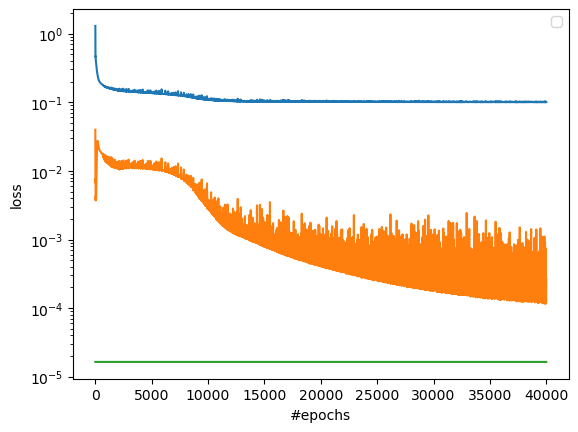

In [69]:
@tf.function
def train_step(Z,model,Zbc1,Zbc2,Zbc3,Zbc4,optimizer):
  loss, grad_theta,loss_res,loss_bc1,loss_bc2,loss_bc3,loss_bc4= loss_grad(Z,model,Zbc1,Zbc2,Zbc3,Zbc4)

  grads_and_vars = [(g, v) for g, v in zip(grad_theta, model.trainable_variables) if g is not None]
  optimizer.apply_gradients(grads_and_vars)

  #optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

  return loss,loss_res,loss_bc1,loss_bc2,loss_bc3,loss_bc4

N=40000

hist=[]

# Start timer
t_begin = time()
hist = []
histres = []
histbc = []
#model.load_weights('lid_driven_cavity.h5')

#lr = keras.optimizers.schedules.PiecewiseConstantDecay([1000,1500,2000],[1e-5,1e-5,1e-5,1e-4])

for i in range(N+1):
    loss,loss_res,loss_bc1,loss_bc2,loss_bc3,loss_bc4 = train_step(Z,model,Zbc1,Zbc2,Zbc3,Zbc4,optim)

    # Append current loss to hist
    hist.append(loss.numpy())
    histres.append(loss_res.numpy())
    histbc.append(loss_bc.numpy())


    if i%5000 == 0:
      print("Epoch:", i, "loss_res:", loss_res.numpy(), "loss_bc1:", loss_bc1.numpy(), "loss_bc2:", loss_bc2.numpy(), "loss_bc3:", loss_bc3.numpy(), "loss_bc4:", loss_bc4.numpy())

    '''if i%500==0 and i!=0:
     #model.save('/content/drive/MyDrive/lid_driven_cavity.h5')
     model.save('lid_driven_cavitys.h5')
'''
# Print the loss
print('\n The loss is: {}'.format(hist[-1]))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t_begin))

model.save('lid_driven_cavitys.h5')

# Print the learning curve
plt.semilogy(range(len(hist)), np.array(hist))
plt.semilogy(range(len(histres)), np.array(histres))
plt.semilogy(range(len(histbc)), np.array(histbc))


plt.legend()

plt.xlabel('#epochs')
plt.ylabel('loss');



In [70]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = 0.1
dt = 0.001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
def build_up_b(b, rho, dt, u, v, dx, dy):

    b[1:-1, 1:-1] = (rho * (1 / dt *
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) /
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()

    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) *
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2

    return p

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))

    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)

        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0


    return u, v, p

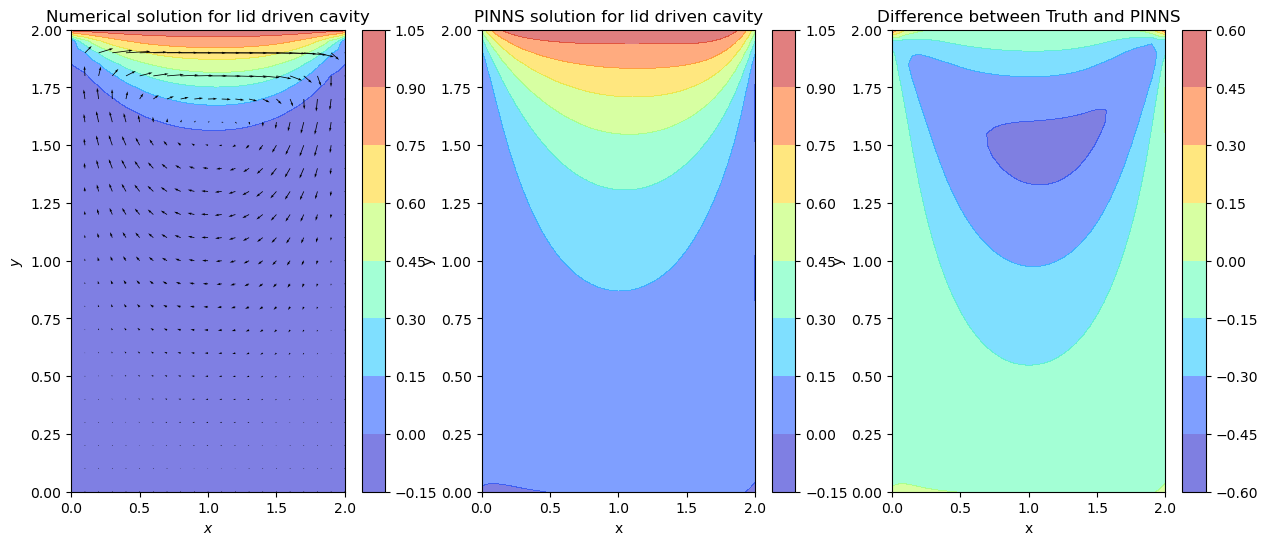

In [71]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

fig,ax= plt.subplots(1,3,figsize=(15,6))
contour=ax[0].contourf(X, Y, u, alpha=0.5, cmap="jet")
ax[0].quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_title('Numerical solution for lid driven cavity')
fig.colorbar(contour, ax=ax[0])

x = np.linspace(0, 2, 41)
y = np.linspace(0, 2, 41)
X, Y = np.meshgrid(x, y)
ZZ=tf.stack([tf.reshape(X,[-1]),tf.reshape(Y,[-1])],1)

p=model(ZZ).numpy()
upinns=p[:,0]
upinns=upinns.reshape(41,41)
vpinns=p[:,1]
vpinns=vpinns.reshape(41,41)
pressure=p[:,2].reshape(41,41)
contour=ax[1].contourf(X, Y, upinns,alpha=0.5, cmap="jet")
#ax[1].quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('PINNS solution for lid driven cavity')
fig.colorbar(contour, ax=ax[1])

contour=ax[2].contourf(X, Y,u-upinns,alpha=0.5, cmap="jet")
#ax[1].quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[2].set_title('Difference between Truth and PINNS')
fig.colorbar(contour, ax=ax[2])
plt.show()

